In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.0/102.0 MB 4.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 3.8 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 5.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 4.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 2.0 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [162]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import yfinance as yf
import talib as ta
import tensorflowjs as tfjs
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History, EarlyStopping
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate


In [163]:
coin_name = "AAVE"
coin_pair = coin_name + "-USD"
ticker = yf.Ticker( coin_pair )
the_data = ticker.history(period='60d',interval="15m")

In [164]:
# Adding indicators
data=the_data.copy()
data.columns = data.columns.get_level_values(0)
data['RSI_15'] = ta.RSI(data.Close, timeperiod=15)
data['RSI_7'] = ta.RSI(data.Close, timeperiod=7)
data['EMAF'] = ta.EMA(data.Close, timeperiod=20)
data['EMAM'] = ta.EMA(data.Close, timeperiod=100)
data['EMAS'] = ta.EMA(data.Close, timeperiod=150)
data['ADX'] = ta.ADX(data['High'], data['Low'], data['Close'])
data = data.dropna()
# print(data)

In [165]:
data['Target'] = data['Close']-data.Open
data['Target'] = data['Target'].shift(-1)
data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
data['TargetNextClose'] = data['Close'].shift(-1)
data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Datetime','Volume','Dividends','Stock Splits'], axis=1, inplace=True)
data = data.loc[:, ['Close','High','Low','Open','RSI_15','RSI_7','EMAF','EMAM','EMAS','ADX','Target','TargetClass','TargetNextClose']]
data_set = data.iloc[:, 0:13]#.values
pd.set_option('display.max_columns', None)

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)


/tmp/ipykernel_42/745180797.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]


In [166]:
X = []
backcandles = 30
total_indicators = 10
for j in range(total_indicators):
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]):
        X[j].append(data_set_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(data_set_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

splitlimit = int(len(X)*0.8)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

np.random.seed(10)

lstm_input = Input(shape=(backcandles, total_indicators), name='lstm_input')

inputs = LSTM(150,name='first_layer')(lstm_input)

inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)

model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1, callbacks=[early_stopping])


Epoch 1/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0111 - val_loss: 2.7168e-04
Epoch 2/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.8993e-04 - val_loss: 4.4347e-04
Epoch 3/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 3.8395e-04 - val_loss: 1.9050e-04
Epoch 4/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.2018e-04 - val_loss: 5.7127e-04
Epoch 5/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1199e-04 - val_loss: 2.9922e-04
Epoch 6/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.0636e-04 - val_loss: 2.9700e-04
Epoch 7/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.6927e-04 - val_loss: 2.2285e-04
Epoch 8/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.2058e-04 - val_loss: 1.3253e-04
Epoch 9/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.9576e-04 - val_loss: 1.6908e-04
Epoch 10/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.5261e-04 - val_loss: 3.2001e-04
Epoch 11/30
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.

In [167]:
model.save('/data/oracle/' + coin_pair + '.keras') 
#tfjs.converters.save_keras_model(model, '/data/oracle/avax-usd-tfjs')


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


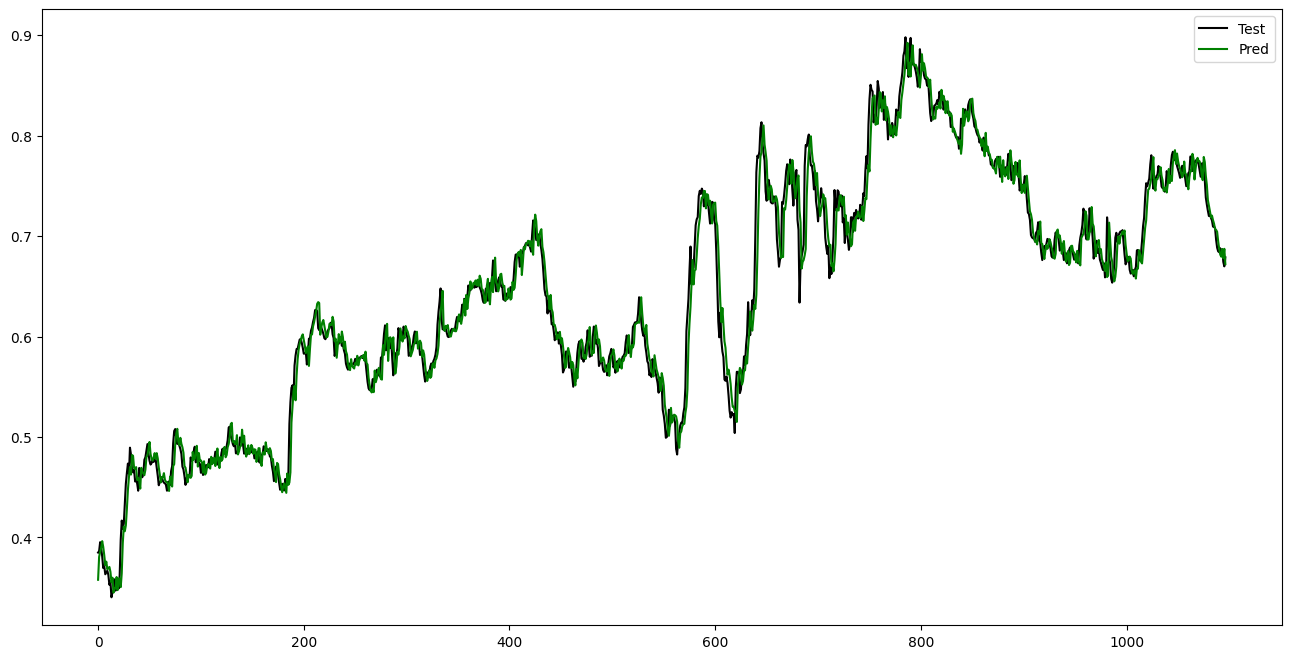

In [169]:
y_pred = model.predict(X_test)
y_pred_original = sc.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], data_set_scaled.shape[1] - 1)), y_pred], axis=1))[:, -1]
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'Pred')
plt.legend()
plt.savefig('/data/oracle/' + coin_pair + '.png')

In [175]:
check_data=data
check_data = check_data.loc[:, ['Close','High','Low','Open','RSI_15','RSI_7','EMAF','EMAM','EMAS','ADX']]
check_data_set = check_data.iloc[:, 0:10]#.values
pd.set_option('display.max_columns', None)
sc = MinMaxScaler(feature_range=(0,1))
check_data_set_scaled = sc.fit_transform(check_data_set)
print( check_data_set )

check_backcandles = 30
check_last_window = check_data_set_scaled[-check_backcandles:, :]
print( check_last_window.shape )
check_input = np.expand_dims(check_last_window, axis=0)

y_pred = model.predict(check_input)
y_pred_original = sc.inverse_transform(np.concatenate([np.zeros((y_pred.shape[0], check_data_set_scaled.shape[1] - 1)), y_pred], axis=1))[:, -1]
print(c)

           Close        High         Low        Open     RSI_15      RSI_7  \
0     205.135529  205.228424  204.169754  204.633163  51.608302  49.400553   
1     203.062668  205.212814  203.062668  205.127747  42.006668  33.050353   
2     202.741257  203.130615  202.649261  203.070374  40.747227  31.183323   
3     203.930450  203.996933  202.708374  202.708374  47.041558  44.674229   
4     199.592636  202.793533  199.585175  202.793533  33.241002  24.355167   
...          ...         ...         ...         ...        ...        ...   
5507  334.890686  334.991241  334.058685  334.058685  23.969103  17.952537   
5508  333.442352  334.780151  333.442352  334.780151  21.829639  14.287076   
5509  334.671173  334.671173  333.112305  333.388580  27.696372  28.697428   
5510  332.144714  334.465271  332.144714  334.465271  23.767060  20.450359   
5511  331.245972  332.317535  331.222076  331.961456  22.547832  18.271178   

            EMAF        EMAM        EMAS        ADX  
0     205